https://www.kaggle.com/code/sainiamit/chest-xray-pneumonia-image-classification

In [1]:
import os
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
%matplotlib inline

seed = 99
np.random.seed(seed)
tf.random.set_seed(seed)

2023-03-23 08:48:03.739347: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Description of the Pneumonia Dataset**

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

In [2]:
input_path = 'chest_xray/'
order = ['train', 'val', 'test']

In [3]:
# https://www.kaggle.com/code/sainiamit/chest-xray-pneumonia-image-classification
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
train = get_training_data(input_path + 'train')
test = get_training_data(input_path + 'test')
val = get_training_data(input_path + 'val')

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_5a1v4y7k9y/croot/opencv-suite_1676472757237/work/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_5a1v4y7k9y/croot/opencv-suite_1676472757237/work/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/var/folders/30/dxk9z97n3sg6ghl0d6b3f_dh0000gn/T/ipykernel_44920/137186227.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_5a1v4y7k9y/croot/opencv-suite_1676472757237/work/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_5a1v4y7k9y/croot/opencv-suite_1676472757237/work/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



## Q1: Exploratory Data Analysis (4 Pts)

Download and explore the data. Explore label distribution and qualitatively describe the data by plotting healthy and pneumonia samples. Do you see visual differences between healthy and disease samples? Do you find sources of bias that could influence model performance? How do you preprocess the data for your further analysis?

**Label distribution**

Set: train, normal images: 1341, pneumonia images: 3875
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 234, pneumonia images: 390


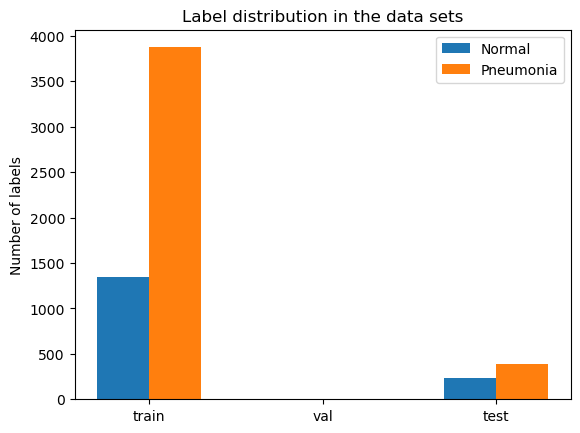

In [5]:
Normal = []
Pneumonia = []
for _set in order:
    li = os.listdir(input_path + _set + '/NORMAL')
    if ('.DS_Store' in li): li.remove('.DS_Store')
    n_normal = len(li)
    Normal.append(n_normal)
    
    la = os.listdir(input_path + _set + '/PNEUMONIA')
    if ('.DS_Store' in la): la.remove('.DS_Store')
    n_infect = len(la)
    Pneumonia.append(n_infect)
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

x = np.arange(len(order))
width = 0.30  
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Normal, width, label='Normal')
rects2 = ax.bar(x + width/2, Pneumonia, width, label='Pneumonia')

ax.set_ylabel('Number of labels')
ax.set_xticks(x)
ax.set_xticklabels(order)
ax.legend()
plt.title("Label distribution in the data sets")
plt.show()

In [ ]:
label_dist = pd.DataFrame({'Normal': Normal, 'Pneumonia': Pneumonia}
                         , index=['Train','Val','Test'])
label_dist

In [ ]:
fig, axes = plt.subplot_mosaic("AAA;BCD")
axes["A"].pie((sum(label_dist['Normal']),sum(label_dist['Pneumonia'])),
        labels=labels,
        autopct='%1.1f%%')
axes["A"].set_title('Label proportion of total data')
axes["B"].pie((label_dist.iloc[0,0],label_dist.iloc[0,1]),
        labels=labels,
        autopct='%1.1f%%')
axes["B"].set_title('Train data')
axes["C"].pie((label_dist.iloc[1,0],label_dist.iloc[1,1]),
        labels=labels,
        autopct='%1.1f%%')
axes["C"].set_title('Validation data')
axes["D"].pie((label_dist.iloc[2,0],label_dist.iloc[2,1]),
        labels=labels,
        autopct='%1.1f%%')
axes["D"].set_title('Test data')

**Healthy vs. pneumonia samples**

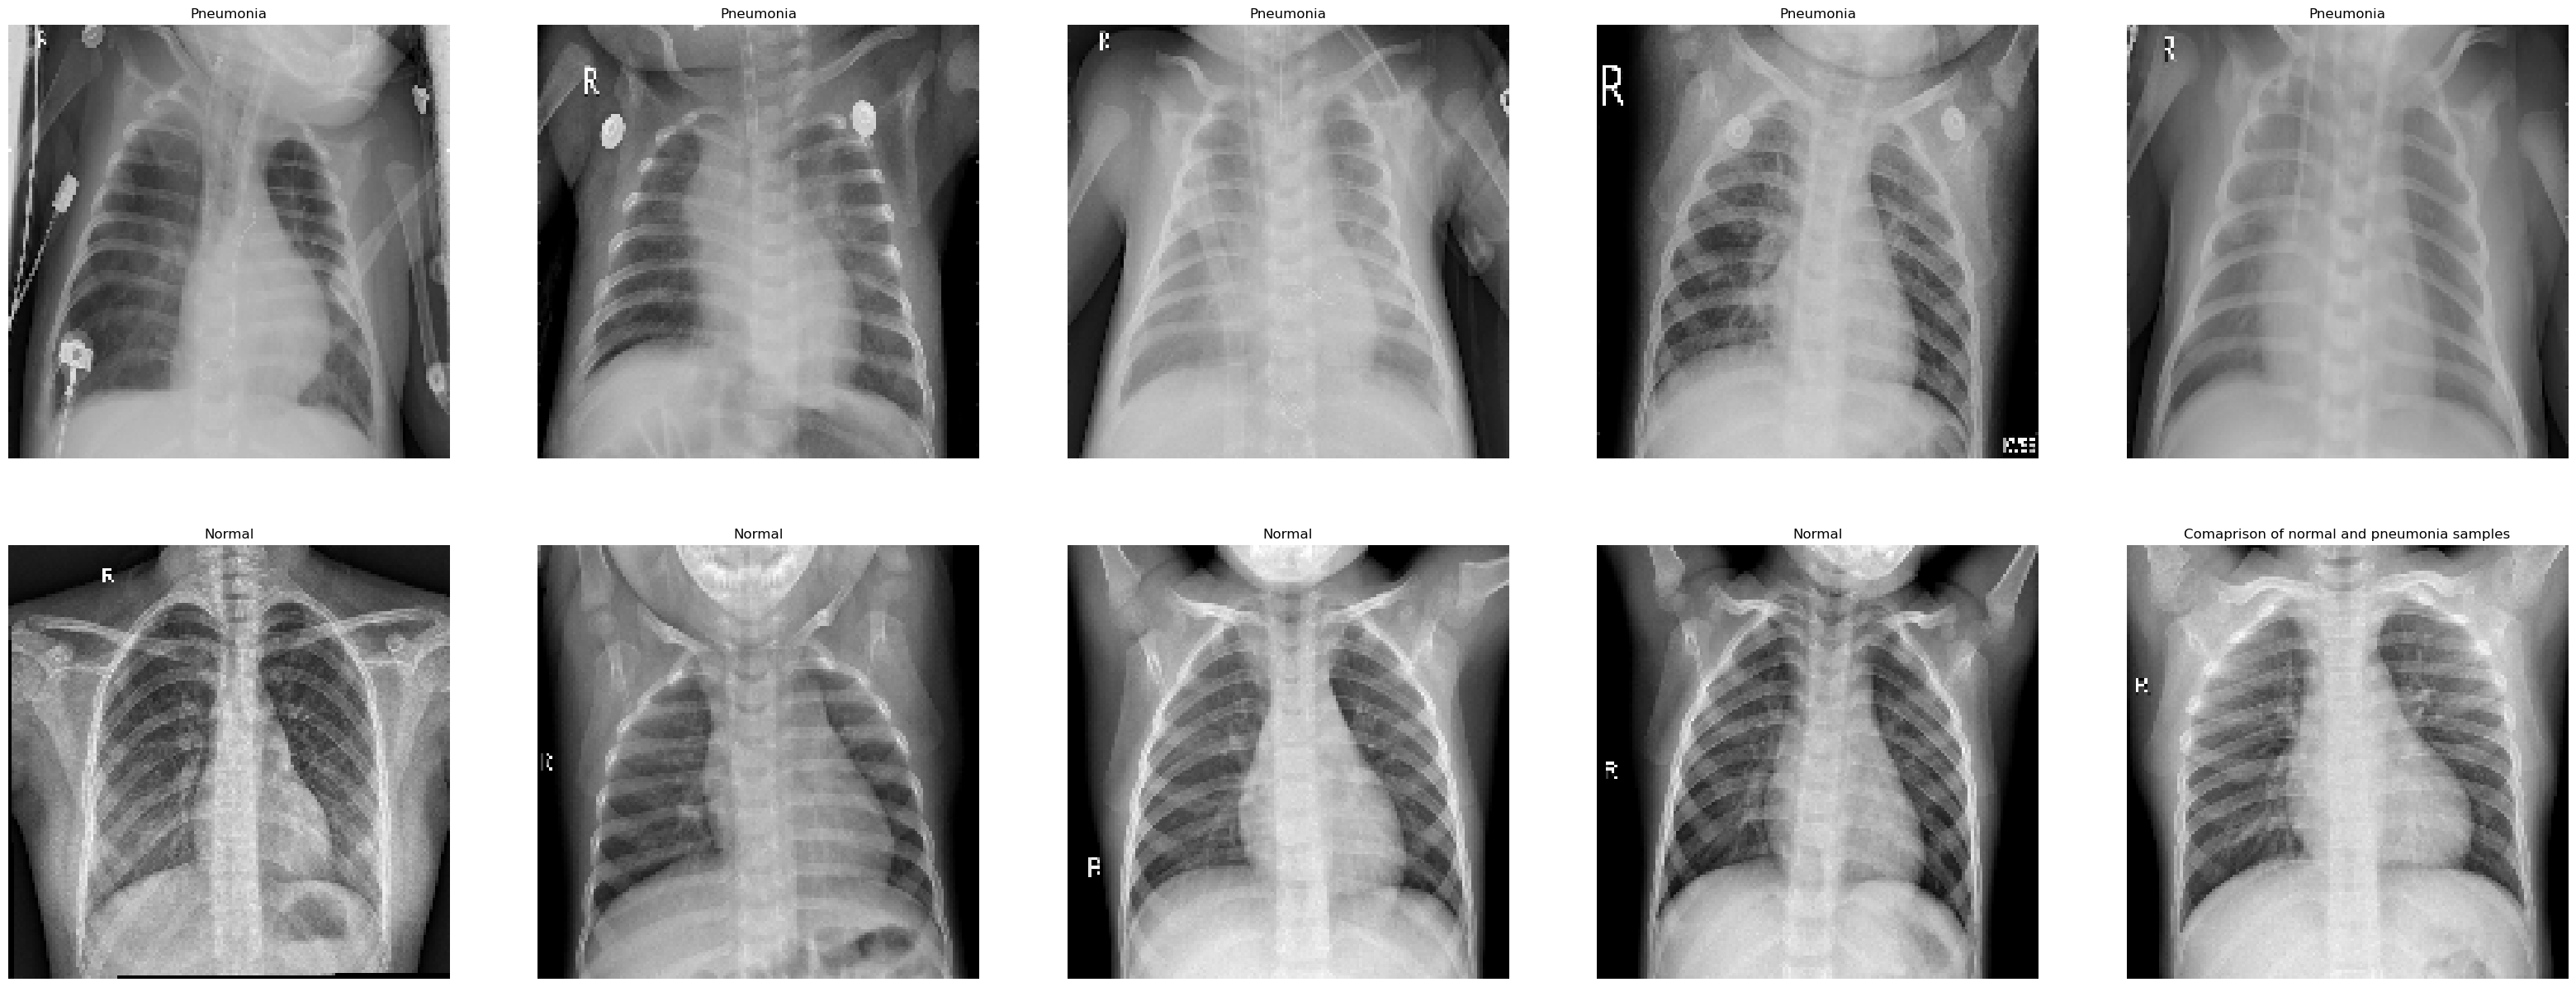

In [6]:
f, ax = plt.subplots(2,5, figsize=(40,15))
j = 0
i = 0
while j < 5:
    if train[i][1] == 0: # Label Pneumonia: 0
        ax[j//5, j%5].imshow(train[i][0], cmap='gray')
        ax[j//5, j%5].set_title("Pneumonia")
        ax[j//5, j%5].axis('off')
        ax[j//5, j%5].set_aspect('auto')
        j+=1
    i+=1
while j < 10:
    if train[i][1] == 1: # Label Normal: 1
        ax[j//5, j%5].imshow(train[i][0], cmap='gray')
        ax[j//5, j%5].set_title("Normal")
        ax[j//5, j%5].axis('off')
        ax[j//5, j%5].set_aspect('auto')
        j+=1
    i+=1
plt.title("Comaprison of normal and pneumonia samples")
plt.show()

In [ ]:
f, ax = plt.subplots(2,5, figsize=(40,15))
j = 0
i = 0
while j < 5:
    if train[i][1] == 0: # Label Pneumonia: 0
        ax[j//5, j%5].imshow(train[i][0])
        ax[j//5, j%5].set_title("Pneumonia")
        ax[j//5, j%5].axis('off')
        ax[j//5, j%5].set_aspect('auto')
        j+=1
    i+=1
while j < 10:
    if train[i][1] == 1: # Label Normal: 1
        ax[j//5, j%5].imshow(train[i][0])
        ax[j//5, j%5].set_title("Normal")
        ax[j//5, j%5].axis('off')
        ax[j//5, j%5].set_aspect('auto')
        j+=1
    i+=1
plt.title("Comaprison of normal and pneumonia samples")
plt.show()

*Do you see visual differences between healthy and disease samples?* 
- Some Pneumoinia cases have white "clounds" in the pictures. The pictures look more "noisy" in the area of the lungs.
- Surgeons apparently see white points and white shaddows 

*Do you find sources of bias that could influence model performance?*
- The labels are not distributed to equal parts. There are more pneumonia cases in the test and training set.
- The validation set is very small, only 0.3% of the training data set

In [18]:
8*2/sum((label_dist.iloc[0,0],label_dist.iloc[0,1]))*100

0.3067484662576687

**Additional preprocessing**

A) Data Augmentation

In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are:
- grayscales
- horizontal flips
- vertical flips
- random crops
- color jitters
- translations
- rotations
- and much more. 

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

Shuffling is applied to the training data to break possible biases during data preparation.

In [20]:
img_size = 224 # or 224
batch_size= 32 # default

train_datagen = ImageDataGenerator(rescale=1/255.,
                #rotation_range = 30, #0  # randomly rotate images in the range (degrees, 0 to 180)
                zoom_range = 0.2, #0.0 # Randomly zoom image 
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip = True)  # Randomly flip inputs horizontally

val_datagen = ImageDataGenerator(rescale=1/255.)

test_datagen = ImageDataGenerator(rescale=1/255.)


train_generator = train_datagen.flow_from_directory('chest_xray/train',
                                                    target_size= (img_size, img_size),
                                                    batch_size = batch_size,
                                                    color_mode='rgb', # default
                                                    shuffle = True,
                                                    class_mode ='binary',
                                                    seed = 99)

val_generator = val_datagen.flow_from_directory('chest_xray/val',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                color_mode='rgb', # default
                                                shuffle = False,
                                                class_mode ='binary',
                                                seed = 99)

test_generator = test_datagen.flow_from_directory('chest_xray/test',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                color_mode='rgb', # default
                                                shuffle = False, 
                                                class_mode ='binary',
                                                seed = 99)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/var/folders/30/dxk9z97n3sg6ghl0d6b3f_dh0000gn/T/ipykernel_39462/1890936299.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5 , 5, i+1)


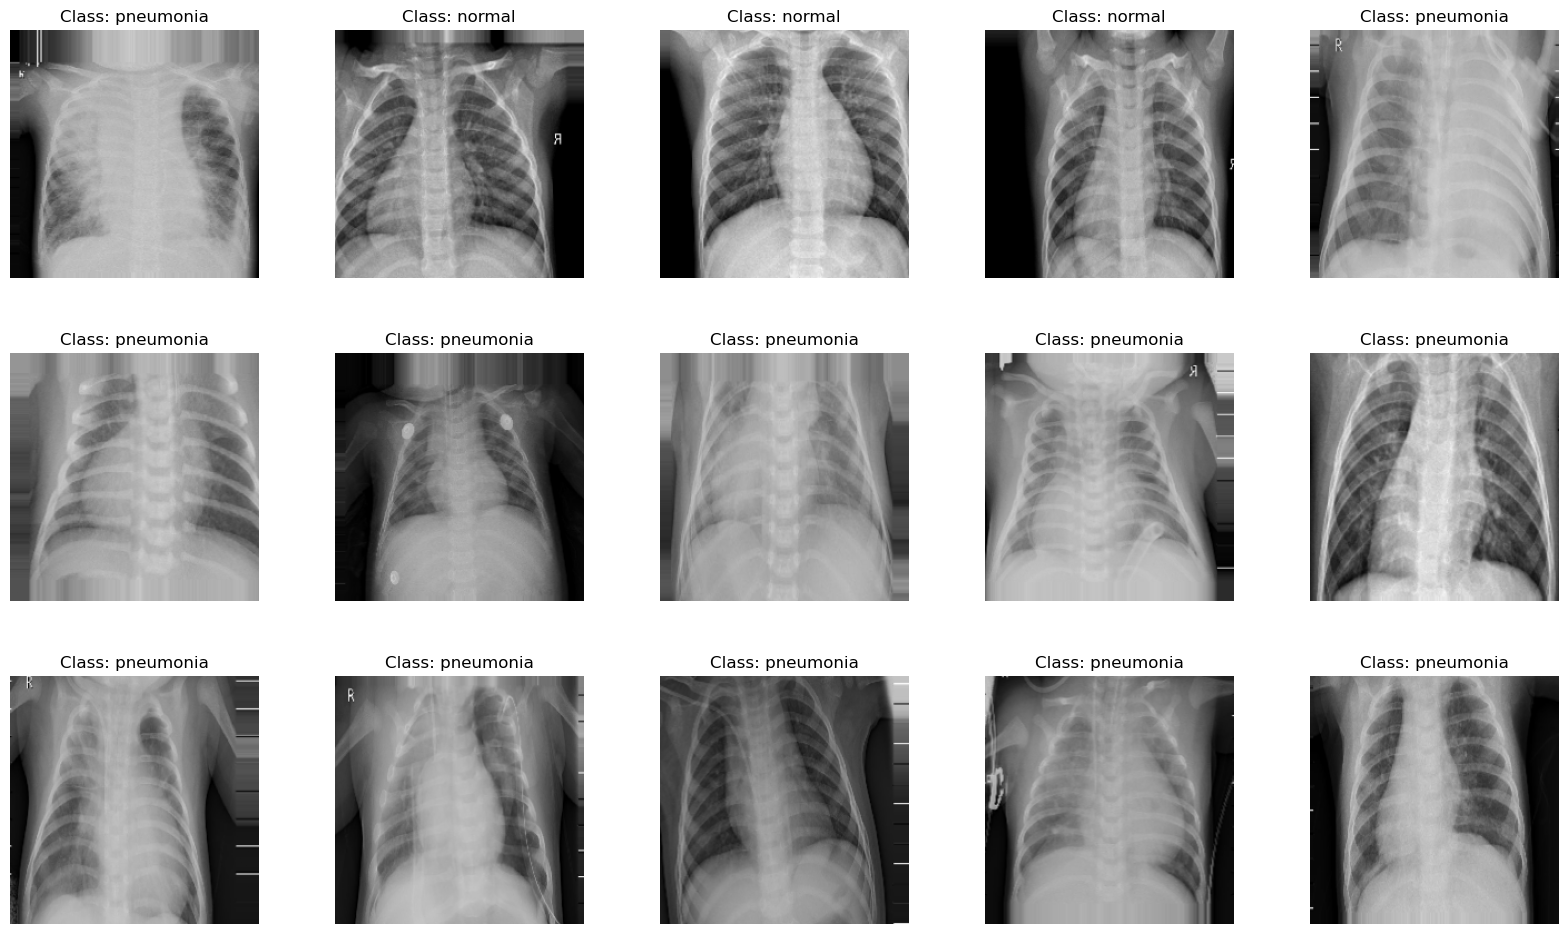

In [35]:
# copied https://www.kaggle.com/code/srishtik05/normal-vs-pneumonia-cnn
labels = ['normal','pneumonia']
samples = train_generator.__next__()
images = samples[0]
target = samples[1]

plt.figure(figsize = (20 , 20))
for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[int(target[i])]}")
    plt.axis('off')

**Q2: CNN Classifier (4 Pts)**

In Q3 and Q4, we aim to use post-hoc explainability methods for visualizing the parts of the image that are important for the prediction of a model. Thus, design a small CNN classifier for the dataset and report its performance on a test set. Make sure to elaborate on your architecture and training details.

Dense layer is used to regularize.

Data augmentation “increased” the data set to reduce the generalization gap (generalization gap: the gap between model performance in the training set and model performance test set).
https://jinwen17.medium.com/tricks-to-prevent-overfitting-in-cnn-model-trained-on-a-small-dataset-b84f05eb4eb7

*Why using recall?*

The problem are false negatives. Thus, a person has pneumonia but the detector says its results are normal. The recall uses the correctly labeled samples w.r.t. all pneumonia samples. It thus includes the relationship to the false negative samples. Thats why recall is an appropriate metric for this case.

In [2]:
# https://www.kaggle.com/code/ishaparanjpe/pneumonia-detection 
channel = 3
cnn = Sequential()

cnn.add(Conv2D(16,3, input_shape=(img_size,img_size,channel), activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Conv2D(32,3, activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Conv2D(64,3, activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Conv2D(64,3, activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Flatten())

cnn.add(Dense(256, activation ='relu'))
cnn.add(Dense(1, activation = 'sigmoid'))

2023-03-23 10:00:15.008744: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'img_size' is not defined

In [ ]:
cnn.compile(optimizer= 'nadam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy', tf.keras.metrics.Recall()])

In [33]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 28, 28, 64)      

In [ ]:
plot_model(cnn, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='cnn_model.png')

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

filepath= "model_cnn"
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
# es = EarlyStopping(monitor='val_loss', patience=4)
history = cnn.fit(train_generator, 
                  validation_data= val_generator,
                  epochs = 10 # 200
                  #, callbacks= [checkpoint]
                 )

In [34]:
history = cnn.fit(train_generator, 
                  validation_data= val_generator,
                  epochs = 10 # 200
                  #, callbacks= [checkpoint]
                 )

Epoch 1/10
163/163 [==============================] - 124s 754ms/step - loss: 0.4456 - accuracy: 0.7985 - recall_1: 0.9285 - val_loss: 1.4419 - val_accuracy: 0.6250 - val_recall_1: 1.0000
Epoch 2/10
163/163 [==============================] - 163s 1s/step - loss: 0.2609 - accuracy: 0.8886 - recall_1: 0.9267 - val_loss: 0.7163 - val_accuracy: 0.7500 - val_recall_1: 1.0000
Epoch 3/10
163/163 [==============================] - 335s 2s/step - loss: 0.2293 - accuracy: 0.9066 - recall_1: 0.9378 - val_loss: 0.6513 - val_accuracy: 0.8125 - val_recall_1: 1.0000
Epoch 4/10
163/163 [==============================] - 157s 961ms/step - loss: 0.2050 - accuracy: 0.9176 - recall_1: 0.9437 - val_loss: 0.9046 - val_accuracy: 0.7500 - val_recall_1: 1.0000
Epoch 5/10
163/163 [==============================] - 91s 555ms/step - loss: 0.1909 - accuracy: 0.9279 - recall_1: 0.9525 - val_loss: 0.5615 - val_accuracy: 0.8125 - val_recall_1: 1.0000
Epoch 6/10
163/163 [==============================] - 91s 559ms/ste

### Evaluation

In [36]:
history_df = pd.DataFrame(history.history)
history_df 

,loss,accuracy,recall_1,val_loss,val_accuracy,val_recall_1
0,0.445593,0.798505,0.928516,1.441905,0.6250,1.0
1,0.260899,0.888612,0.926710,0.716308,0.7500,1.0
2,0.229324,0.906633,0.937806,0.651341,0.8125,1.0
3,0.204970,0.917561,0.943742,0.904605,0.7500,1.0
4,0.190876,0.927914,0.952516,0.561457,0.8125,1.0
5,0.165073,0.938267,0.958452,1.053666,0.6250,1.0
6,0.157478,0.938842,0.957161,1.293691,0.6250,1.0
7,0.143082,0.946127,0.964645,1.319970,0.6250,1.0
8,0.160387,0.937692,0.958968,0.951682,0.6250,1.0
9,0.134691,0.947086,0.962065,0.723541,0.8125,1.0


**Overfitting**

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

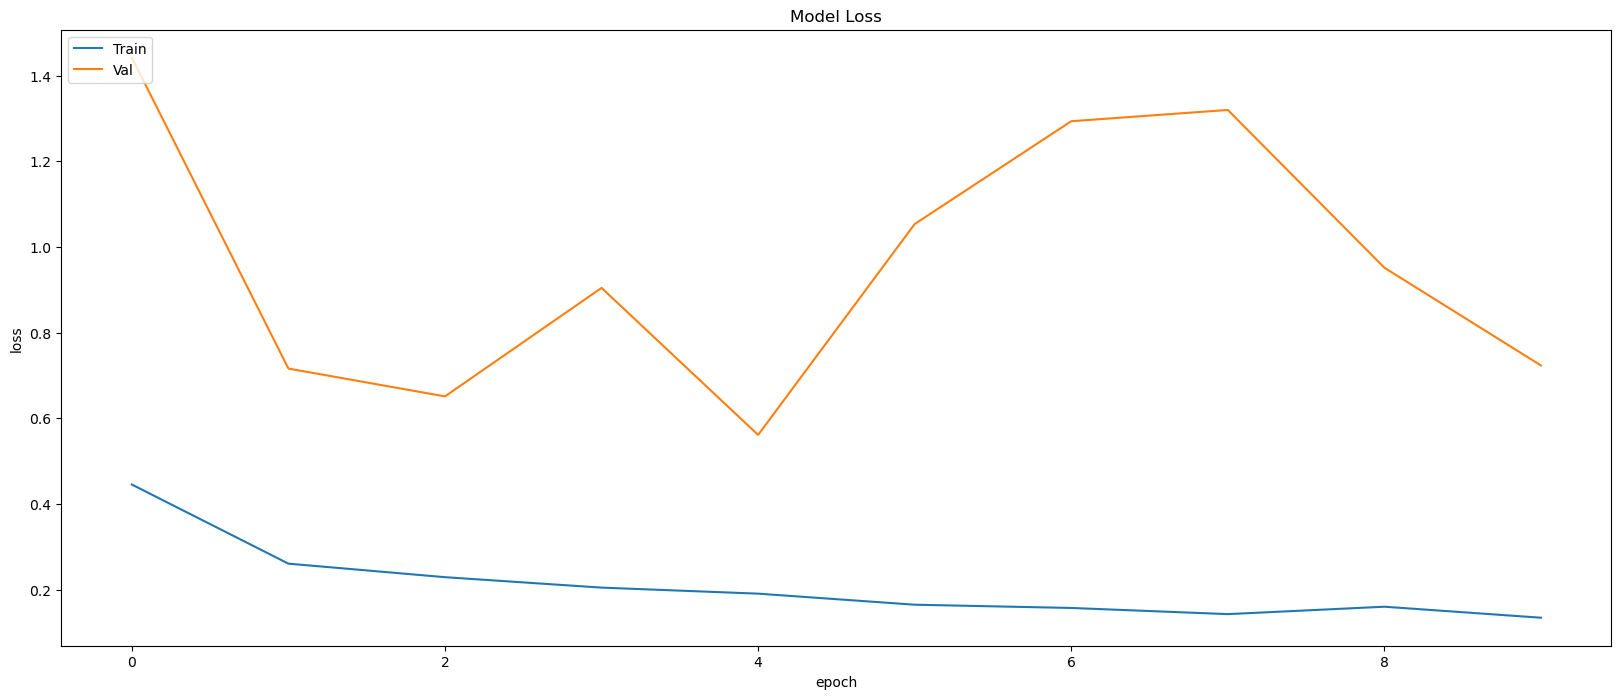

In [37]:
plt.figure(figsize=(20,8))
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

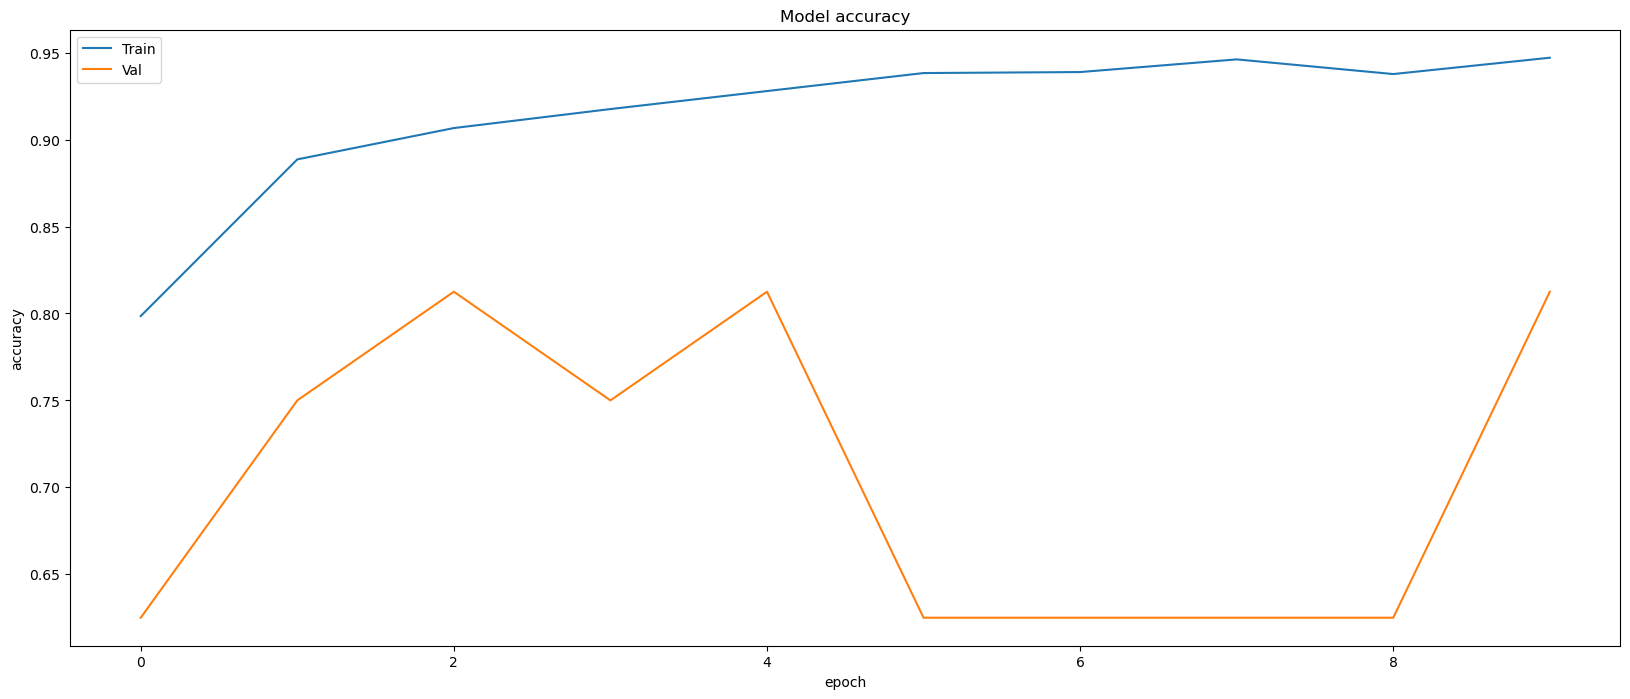

In [39]:
plt.figure(figsize=(20,8))
plt.plot(history_df['accuracy'])
plt.plot(history_df['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

**Evalution on validation data**

In [40]:
classes = val_generator.classes
y_pred = cnn.predict(val_generator)
y_pred[y_pred>0.5] = 1
y_pred[y_pred<0.5] = 0

1/1 [==============================] - 1s 614ms/step


In [41]:
print(classification_report(classes,y_pred,target_names=labels))

              precision    recall  f1-score   support

      normal       1.00      0.62      0.77         8
   pneumonia       0.73      1.00      0.84         8

    accuracy                           0.81        16
   macro avg       0.86      0.81      0.81        16
weighted avg       0.86      0.81      0.81        16



In [42]:
print(confusion_matrix(classes,y_pred))

[[5 3]
 [0 8]]


In [43]:
acc = accuracy_score(classes,y_pred)
print(acc*100)

81.25


**Evalution on test data**

In [44]:
tester = cnn.evaluate(test_generator)

20/20 [==============================] - 4s 201ms/step - loss: 0.3287 - accuracy: 0.9103 - recall_1: 0.9846


In [45]:
print("Loss of the model is - " , cnn.evaluate(test_generator)[0])
print("Accuracy of the model is - " , cnn.evaluate(test_generator)[1]*100 , "%")

20/20 [==============================] - 4s 201ms/step - loss: 0.3287 - accuracy: 0.9103 - recall_1: 0.9846
Loss of the model is -  0.3286665380001068
20/20 [==============================] - 4s 197ms/step - loss: 0.3287 - accuracy: 0.9103 - recall_1: 0.9846
Accuracy of the model is -  91.02563858032227 %


In [46]:
classes = test_generator.classes
y_preds = cnn.predict(test_generator)
y_pred_probs = y_preds.copy()
y_preds[y_preds>0.5] = 1
y_preds[y_preds<0.5] = 0

20/20 [==============================] - 4s 203ms/step


**Classification report**

In [47]:
print(classification_report(classes,y_preds,target_names=labels))

              precision    recall  f1-score   support

      normal       0.97      0.79      0.87       234
   pneumonia       0.88      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.89      0.90       624
weighted avg       0.92      0.91      0.91       624



In [ ]:
##### plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(classes,y_preds),annot=True,fmt='.3g',xticklabels=['NORMAL','PNEUMONIA'],
            yticklabels=['NORMAL','PNEUMONIA'],cmap='Blues')
plt.show()

In [52]:
acc = accuracy_score(classes,y_preds)
print(f'Accuracy of model is',acc*100)

recall_test = recall_score(classes,y_preds)
print(f'Recall of model is',recall_test*100)

prec = precision_score(classes,y_preds)
print(f'Precision of model is',prec*100)

f1 = f1_score(classes,y_preds)
print(f'F1 Score of model is', f1*100)

Accuracy of model is 91.02564102564102
Recall of model is 98.46153846153847
Precision of model is 88.47926267281106
F1 Score of model is 93.20388349514563


In [ ]:
from sklearn.metrics import roc_curve, auc
y_preds = preds.ravel()
model_fpr, model_tpr, model_threshold = roc_curve(test_labels, y_preds)
model_auc = auc(model_fpr, model_tpr)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(model_fpr, model_tpr, label='AUC Score(area = {:.3f})'.format(model_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('DenseNet 121 using class weights - ROC curve ')
plt.legend(loc='best')
plt.show()

## Model 1 - Rgb, light DA

In [37]:
img_size = 224 # or 224
batch_size= 32 # default

train_datagen = ImageDataGenerator(rescale=1/255.,
                #rotation_range = 30, #0  # randomly rotate images in the range (degrees, 0 to 180)
                zoom_range = 0.2, #0.0 # Randomly zoom image 
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip = True)  # Randomly flip inputs horizontally

val_datagen = ImageDataGenerator(rescale=1/255.)

test_datagen = ImageDataGenerator(rescale=1/255.)


train_generator = train_datagen.flow_from_directory('chest_xray/train',
                                                    target_size= (img_size, img_size),
                                                    batch_size = batch_size,
                                                    color_mode='rgb', # default
                                                    shuffle = True,
                                                    class_mode ='binary',
                                                    seed = 99)

val_generator = val_datagen.flow_from_directory('chest_xray/val',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                color_mode='rgb', # default
                                                shuffle = False,
                                                class_mode ='binary',
                                                seed = 99)

test_generator = test_datagen.flow_from_directory('chest_xray/test',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                color_mode='rgb', # default
                                                shuffle = False, 
                                                class_mode ='binary',
                                                seed = 99)

# https://www.kaggle.com/code/ishaparanjpe/pneumonia-detection 
channel = 3
cnn = Sequential()

cnn.add(Conv2D(16,3, input_shape=(img_size,img_size,channel), activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Conv2D(32,3, activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Conv2D(64,3, activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Conv2D(64,3, activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Flatten())

cnn.add(Dense(256, activation ='relu'))
cnn.add(Dense(1, activation = 'sigmoid'))

filepath= "model_1"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             # mode='min', # since we minimize val_loss
                             verbose=1,
                             # save_freq='epoch', #default: 'epoch'
                             save_best_only=True, #default: F
                             # save_weights_only=False #default: F
                            )
# es = EarlyStopping(monitor='val_loss', patience=5)
# lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1)
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, mode='min', verbose = 1)
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

cnn.compile(optimizer= 'nadam',
            # optimizer= Adam(learning_rate=base_learning_rate/10) # Overfittung prevention
             loss = 'binary_crossentropy',
             metrics = ['accuracy', tf.keras.metrics.Recall()])

history = cnn.fit(train_generator, 
                  validation_data= val_generator,
                  epochs = 10 # 200
                  , callbacks= [checkpoint])

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/10
163/163 [==============================] - ETA: 0s - loss: 0.4688 - accuracy: 0.7732 - recall_6: 0.9115
Epoch 1: val_loss improved from inf to 0.77596, saving model to model_1


INFO:tensorflow:Assets written to: model_1/assets


INFO:tensorflow:Assets written to: model_1/assets


163/163 [==============================] - 98s 595ms/step - loss: 0.4688 - accuracy: 0.7732 - recall_6: 0.9115 - val_loss: 0.7760 - val_accuracy: 0.5000 - val_recall_6: 1.0000
Epoch 2/10
163/163 [==============================] - ETA: 0s - loss: 0.3116 - accuracy: 0.8629 - recall_6: 0.9254
Epoch 2: val_loss did not improve from 0.77596
163/163 [==============================] - 101s 619ms/step - loss: 0.3116 - accuracy: 0.8629 - recall_6: 0.9254 - val_loss: 0.8950 - val_accuracy: 0.7500 - val_recall_6: 1.0000
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.2661 - accuracy: 0.8896 - recall_6: 0.9357
Epoch 3: val_loss did not improve from 0.77596
163/163 [==============================] - 103s 631ms/step - loss: 0.2661 - accuracy: 0.8896 - recall_6: 0.9357 - val_loss: 0.8791 - val_accuracy: 0.7500 - val_recall_6: 1.0000
Epoch 4/10
163/163 [==============================] - ETA: 0s - loss: 0.1942 - accuracy: 0.9243 - recall_6: 0.9525
Epoch 4: val_loss improved from

INFO:tensorflow:Assets written to: model_1/assets


INFO:tensorflow:Assets written to: model_1/assets


163/163 [==============================] - 102s 627ms/step - loss: 0.1942 - accuracy: 0.9243 - recall_6: 0.9525 - val_loss: 0.6833 - val_accuracy: 0.7500 - val_recall_6: 1.0000
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.1672 - accuracy: 0.9363 - recall_6: 0.9608
Epoch 5: val_loss improved from 0.68333 to 0.56889, saving model to model_1


INFO:tensorflow:Assets written to: model_1/assets


INFO:tensorflow:Assets written to: model_1/assets


163/163 [==============================] - 98s 601ms/step - loss: 0.1672 - accuracy: 0.9363 - recall_6: 0.9608 - val_loss: 0.5689 - val_accuracy: 0.7500 - val_recall_6: 1.0000
Epoch 6/10
163/163 [==============================] - ETA: 0s - loss: 0.1542 - accuracy: 0.9410 - recall_6: 0.9600
Epoch 6: val_loss improved from 0.56889 to 0.40528, saving model to model_1


INFO:tensorflow:Assets written to: model_1/assets


INFO:tensorflow:Assets written to: model_1/assets


163/163 [==============================] - 101s 616ms/step - loss: 0.1542 - accuracy: 0.9410 - recall_6: 0.9600 - val_loss: 0.4053 - val_accuracy: 0.8125 - val_recall_6: 1.0000
Epoch 7/10
163/163 [==============================] - ETA: 0s - loss: 0.1463 - accuracy: 0.9415 - recall_6: 0.9579
Epoch 7: val_loss did not improve from 0.40528
163/163 [==============================] - 98s 598ms/step - loss: 0.1463 - accuracy: 0.9415 - recall_6: 0.9579 - val_loss: 0.6868 - val_accuracy: 0.7500 - val_recall_6: 1.0000
Epoch 8/10
163/163 [==============================] - ETA: 0s - loss: 0.1368 - accuracy: 0.9494 - recall_6: 0.9639
Epoch 8: val_loss did not improve from 0.40528
163/163 [==============================] - 96s 586ms/step - loss: 0.1368 - accuracy: 0.9494 - recall_6: 0.9639 - val_loss: 1.0035 - val_accuracy: 0.6250 - val_recall_6: 1.0000
Epoch 9/10
163/163 [==============================] - ETA: 0s - loss: 0.1414 - accuracy: 0.9452 - recall_6: 0.9608
Epoch 9: val_loss did not improv

In [ ]:
plot_model(cnn, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='cnn_model.png')

In [33]:
final_model = load_model(filepath)
classes = test_generator.classes
y_pred = final_model.predict(test_generator)
y_pred[y_pred>0.5] = 1
y_pred[y_pred<0.5] = 0

20/20 [==============================] - 4s 199ms/step


              precision    recall  f1-score   support

      Normal       0.96      0.74      0.84       234
   Pneumonia       0.86      0.98      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.86      0.88       624
weighted avg       0.90      0.89      0.89       624



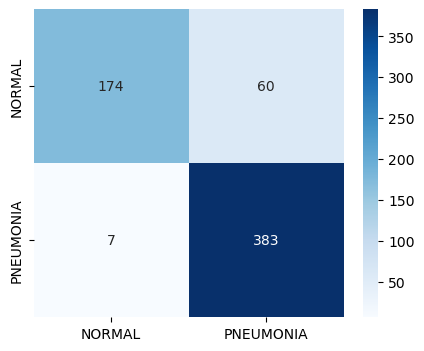

Accuracy of model is 89.26282051282051
Recall of model is 98.2051282051282
Precision of model is 86.45598194130926
F1 Score of model is 91.95678271308523


In [34]:
print(classification_report(classes,y_preds,target_names=labels))
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(classes,y_preds),annot=True,fmt='.3g',xticklabels=['NORMAL','PNEUMONIA'],
            yticklabels=['NORMAL','PNEUMONIA'],cmap='Blues')
plt.show()
acc = accuracy_score(classes,y_preds)
print(f'Accuracy of model is',acc*100)

recall_test = recall_score(classes,y_preds)
print(f'Recall of model is',recall_test*100)

prec = precision_score(classes,y_preds)
print(f'Precision of model is',prec*100)

f1 = f1_score(classes,y_preds)
print(f'F1 Score of model is', f1*100)

20/20 [==============================] - 4s 193ms/step
              precision    recall  f1-score   support

      Normal       0.96      0.74      0.84       234
   Pneumonia       0.86      0.98      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.86      0.88       624
weighted avg       0.90      0.89      0.89       624



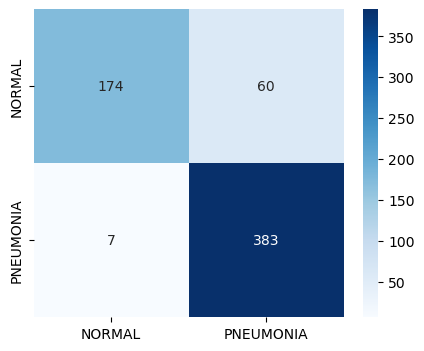

Accuracy of model is 89.26282051282051
Recall of model is 98.2051282051282
Precision of model is 86.45598194130926
F1 Score of model is 91.95678271308523


In [35]:
history_df = pd.DataFrame(history.history)
tester = cnn.evaluate(test_generator)
classes = test_generator.classes
y_preds = cnn.predict(test_generator)
y_pred_probs = y_preds.copy()
y_preds[y_preds>0.5] = 1
y_preds[y_preds<0.5] = 0
print(classification_report(classes,y_preds,target_names=labels))
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(classes,y_preds),annot=True,fmt='.3g',xticklabels=['NORMAL','PNEUMONIA'],
            yticklabels=['NORMAL','PNEUMONIA'],cmap='Blues')
plt.show()
acc = accuracy_score(classes,y_preds)
print(f'Accuracy of model is',acc*100)

recall_test = recall_score(classes,y_preds)
print(f'Recall of model is',recall_test*100)

prec = precision_score(classes,y_preds)
print(f'Precision of model is',prec*100)

f1 = f1_score(classes,y_preds)
print(f'F1 Score of model is', f1*100)

## Model 2 - Grayscale

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


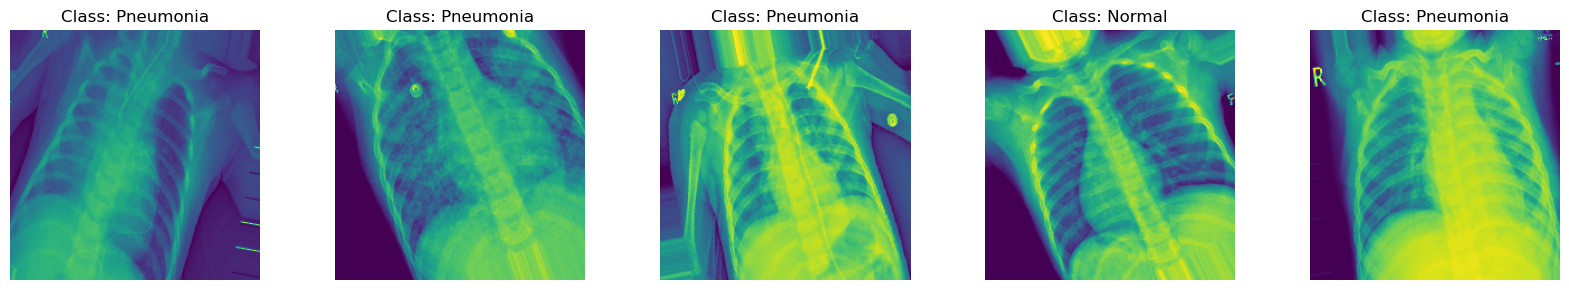

In [7]:
img_size = 224 # or 224
batch_size= 32 # default
color = 'grayscale'

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range=30,
                                   brightness_range=[0.2,1.2],
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale = 1./255.,)
test_datagen = ImageDataGenerator(rescale = 1./255.,)

val_datagen = ImageDataGenerator(rescale=1/255.)

test_datagen = ImageDataGenerator(rescale=1/255.)


train_generator = train_datagen.flow_from_directory('chest_xray/train',
                                                    target_size= (img_size, img_size),
                                                    batch_size = batch_size,
                                                    color_mode=color, # default
                                                    shuffle = True,
                                                    class_mode ='binary',
                                                    seed = 99)

val_generator = val_datagen.flow_from_directory('chest_xray/val',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                color_mode=color, # default
                                                shuffle = False,
                                                class_mode ='binary',
                                                seed = 99)

test_generator = test_datagen.flow_from_directory('chest_xray/test',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                color_mode=color, # default
                                                shuffle = False, 
                                                class_mode ='binary',
                                                seed = 99)
labels = ['Normal','Pneumonia']
samples = train_generator.__next__()
images = samples[0]
target = samples[1]

plt.figure(figsize = (20 , 20))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[int(target[i])]}")
    plt.axis('off')
plt.show()

2023-03-20 15:10:50.125105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
163/163 [==============================] - 60s 361ms/step - loss: 0.4182 - accuracy: 0.8041 - recall: 0.9084 - val_loss: 1.4957 - val_accuracy: 0.6250 - val_recall: 1.0000
Epoch 2/10
163/163 [==============================] - 57s 348ms/step - loss: 0.2786 - accuracy: 0.8817 - recall: 0.9130 - val_loss: 1.8773 - val_accuracy: 0.5625 - val_recall: 1.0000
Epoch 3/10
163/163 [==============================] - 59s 358ms/step - loss: 0.2322 - accuracy: 0.8995 - recall: 0.9259 - val_loss: 1.1124 - val_accuracy: 0.5625 - val_recall: 1.0000
Epoch 4/10
163/163 [==============================] - 57s 351ms/step - loss: 0.2198 - accuracy: 0.9084 - recall: 0.9347 - val_loss: 1.2592 - val_accuracy: 0.6250 - val_recall: 1.0000
Epoch 5/10
163/163 [==============================] - 61s 371ms/step - loss: 0.1882 - accuracy: 0.9254 - recall: 0.9468 - val_loss: 0.8184 - val_accuracy: 0.6875 - val_recall: 1.0000
Epoch 6/10
163/163 [==============================] - 58s 354ms/step - loss: 0.1695 -

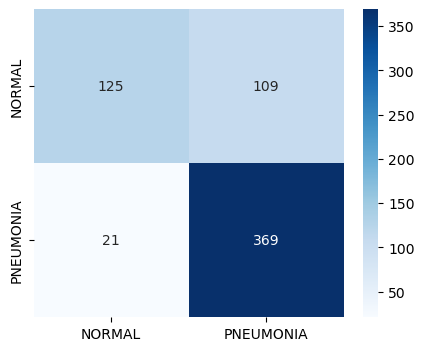

Accuracy of model is 79.16666666666666
Recall of model is 94.61538461538461
Precision of model is 77.19665271966527
F1 Score of model is 85.02304147465438


In [8]:
# https://www.kaggle.com/code/ishaparanjpe/pneumonia-detection 
channel = 1
cnn = Sequential()

cnn.add(Conv2D(16,3, input_shape=(img_size,img_size,channel), activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Conv2D(32,3, activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Conv2D(64,3, activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Conv2D(64,3, activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Flatten())

cnn.add(Dense(256, activation ='relu'))
cnn.add(Dense(1, activation = 'sigmoid'))

cnn.compile(optimizer= 'nadam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy', tf.keras.metrics.Recall()])

history = cnn.fit(train_generator, 
                  validation_data= val_generator,
                  epochs = 10 # 200
                  #, callbacks= [checkpoint]
                 )

history_df = pd.DataFrame(history.history)
tester = cnn.evaluate(test_generator)
classes = test_generator.classes
y_preds = cnn.predict(test_generator)
y_pred_probs = y_preds.copy()
y_preds[y_preds>0.5] = 1
y_preds[y_preds<0.5] = 0
print(classification_report(classes,y_preds,target_names=labels))
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(classes,y_preds),annot=True,fmt='.3g',xticklabels=['NORMAL','PNEUMONIA'],
            yticklabels=['NORMAL','PNEUMONIA'],cmap='Blues')
plt.show()
acc = accuracy_score(classes,y_preds)
print(f'Accuracy of model is',acc*100)

recall_test = recall_score(classes,y_preds)
print(f'Recall of model is',recall_test*100)

prec = precision_score(classes,y_preds)
print(f'Precision of model is',prec*100)

f1 = f1_score(classes,y_preds)
print(f'F1 Score of model is', f1*100)

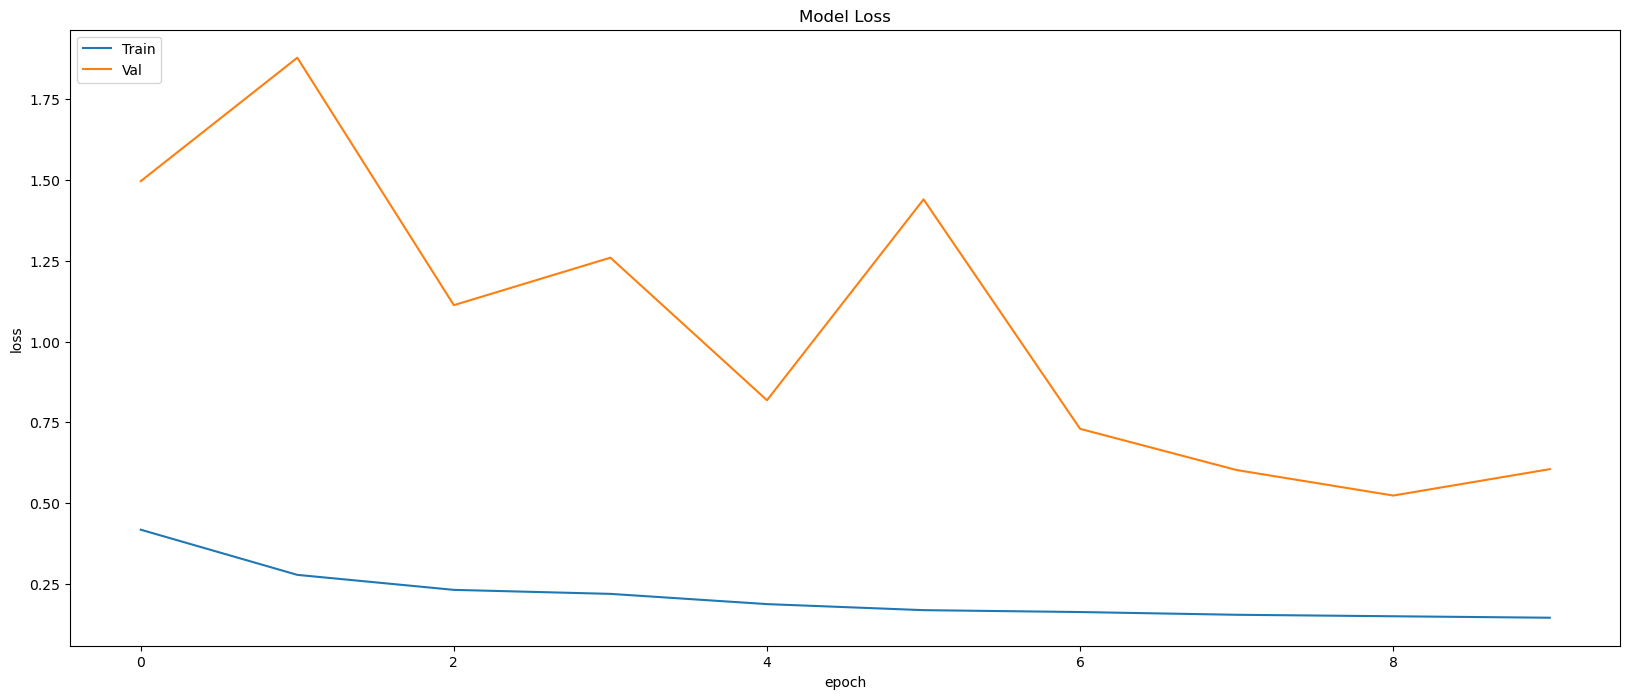

In [9]:
plt.figure(figsize=(20,8))
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

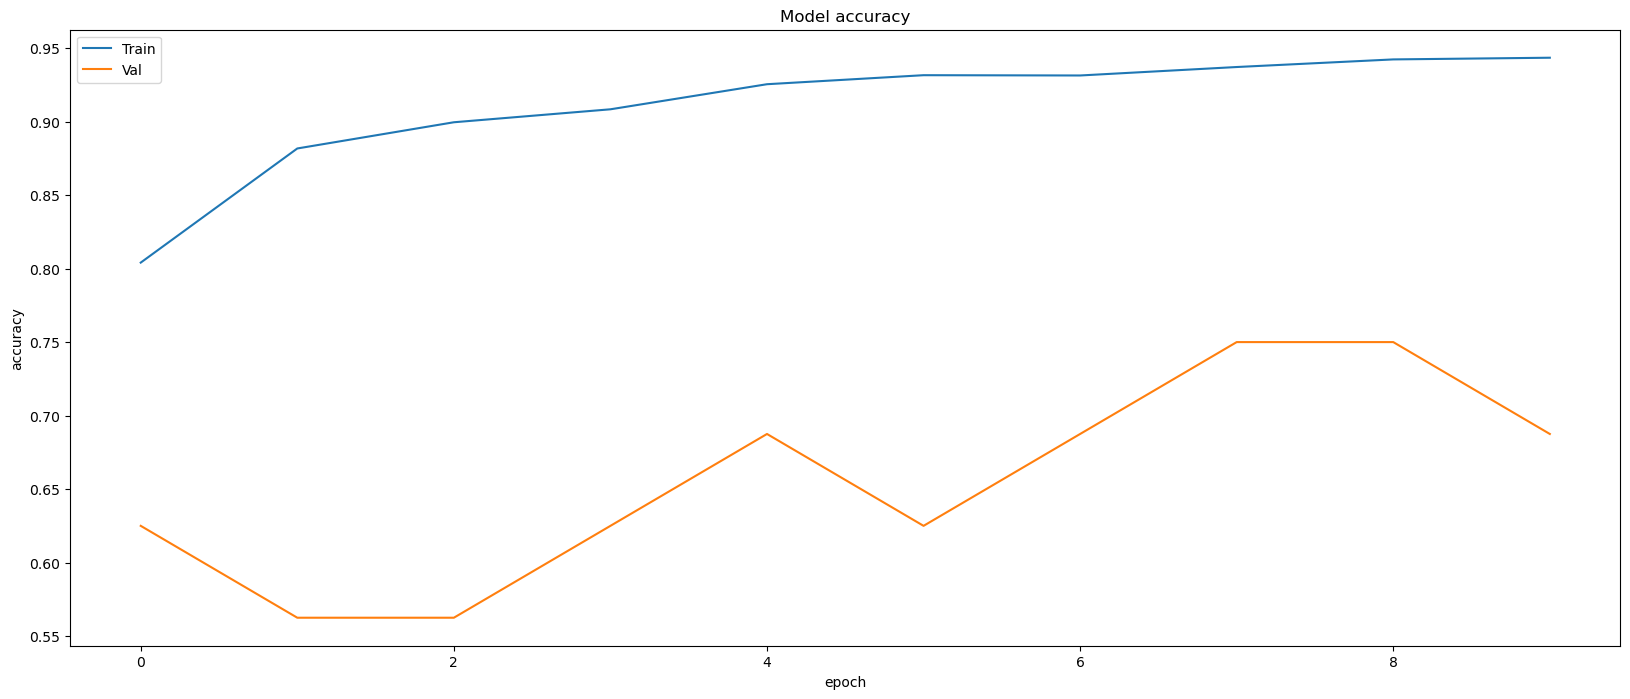

In [10]:
plt.figure(figsize=(20,8))
plt.plot(history_df['accuracy'])
plt.plot(history_df['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Model 3 - Rgb, heavier DA

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


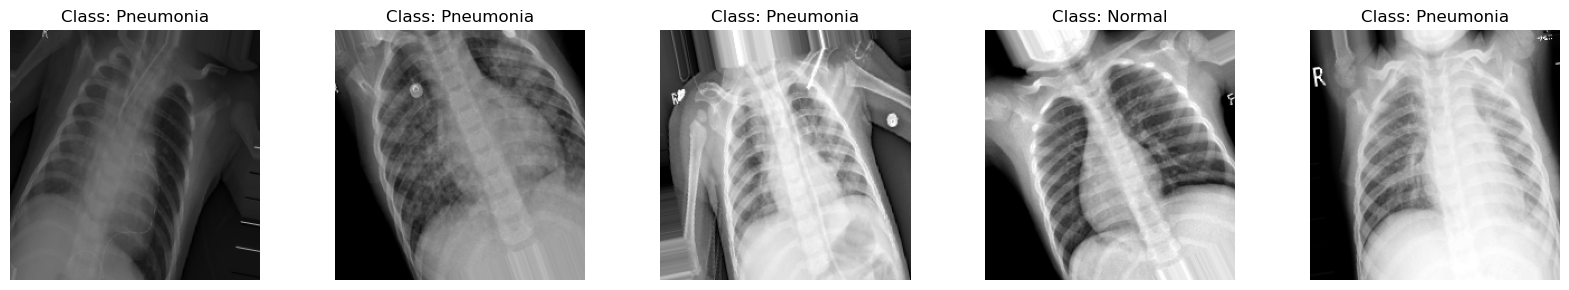

In [11]:
img_size = 224 # or 224
batch_size= 32 # default
color = 'rgb'

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range=30,
                                   brightness_range=[0.6,1.2],
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale = 1./255.,)
test_datagen = ImageDataGenerator(rescale = 1./255.,)

val_datagen = ImageDataGenerator(rescale=1/255.)

test_datagen = ImageDataGenerator(rescale=1/255.)


train_generator = train_datagen.flow_from_directory('chest_xray/train',
                                                    target_size= (img_size, img_size),
                                                    batch_size = batch_size,
                                                    color_mode=color, # default
                                                    shuffle = True,
                                                    class_mode ='binary',
                                                    seed = 99)

val_generator = val_datagen.flow_from_directory('chest_xray/val',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                color_mode=color, # default
                                                shuffle = False,
                                                class_mode ='binary',
                                                seed = 99)

test_generator = test_datagen.flow_from_directory('chest_xray/test',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                color_mode=color, # default
                                                shuffle = False, 
                                                class_mode ='binary',
                                                seed = 99)
labels = ['Normal','Pneumonia']
samples = train_generator.__next__()
images = samples[0]
target = samples[1]

plt.figure(figsize = (20 , 20))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[int(target[i])]}")
    plt.axis('off')
plt.show()

Epoch 1/10
163/163 [==============================] - 104s 630ms/step - loss: 0.3795 - accuracy: 0.8177 - recall_1: 0.8996 - val_loss: 1.4837 - val_accuracy: 0.6250 - val_recall_1: 1.0000
Epoch 2/10
163/163 [==============================] - 104s 635ms/step - loss: 0.2687 - accuracy: 0.8852 - recall_1: 0.9200 - val_loss: 0.6140 - val_accuracy: 0.8125 - val_recall_1: 1.0000
Epoch 3/10
163/163 [==============================] - 375s 2s/step - loss: 0.2206 - accuracy: 0.9105 - recall_1: 0.9337 - val_loss: 0.4324 - val_accuracy: 0.8125 - val_recall_1: 0.8750
Epoch 4/10
163/163 [==============================] - 103s 628ms/step - loss: 0.1929 - accuracy: 0.9235 - recall_1: 0.9435 - val_loss: 0.3523 - val_accuracy: 0.8750 - val_recall_1: 1.0000
Epoch 5/10
163/163 [==============================] - 104s 636ms/step - loss: 0.1770 - accuracy: 0.9317 - recall_1: 0.9505 - val_loss: 0.2570 - val_accuracy: 0.8750 - val_recall_1: 0.8750
Epoch 6/10
163/163 [==============================] - 101s 618m

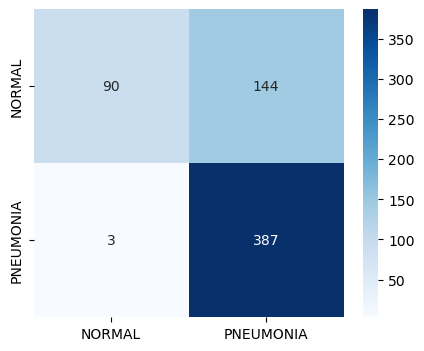

Accuracy of model is 76.4423076923077
Recall of model is 99.23076923076923
Precision of model is 72.88135593220339
F1 Score of model is 84.03908794788273


In [12]:
# https://www.kaggle.com/code/ishaparanjpe/pneumonia-detection 
channel = 3
cnn = Sequential()

cnn.add(Conv2D(16,3, input_shape=(img_size,img_size,channel), activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Conv2D(32,3, activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Conv2D(64,3, activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Conv2D(64,3, activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Flatten())

cnn.add(Dense(256, activation ='relu'))
cnn.add(Dense(1, activation = 'sigmoid'))

cnn.compile(optimizer= 'nadam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy', tf.keras.metrics.Recall()])

history = cnn.fit(train_generator, 
                  validation_data= val_generator,
                  epochs = 10 # 200
                  #, callbacks= [checkpoint]
                 )

history_df = pd.DataFrame(history.history)
tester = cnn.evaluate(test_generator)
classes = test_generator.classes
y_preds = cnn.predict(test_generator)
y_pred_probs = y_preds.copy()
y_preds[y_preds>0.5] = 1
y_preds[y_preds<0.5] = 0
print(classification_report(classes,y_preds,target_names=labels))
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(classes,y_preds),annot=True,fmt='.3g',xticklabels=['NORMAL','PNEUMONIA'],
            yticklabels=['NORMAL','PNEUMONIA'],cmap='Blues')
plt.show()
acc = accuracy_score(classes,y_preds)
print(f'Accuracy of model is',acc*100)

recall_test = recall_score(classes,y_preds)
print(f'Recall of model is',recall_test*100)

prec = precision_score(classes,y_preds)
print(f'Precision of model is',prec*100)

f1 = f1_score(classes,y_preds)
print(f'F1 Score of model is', f1*100)

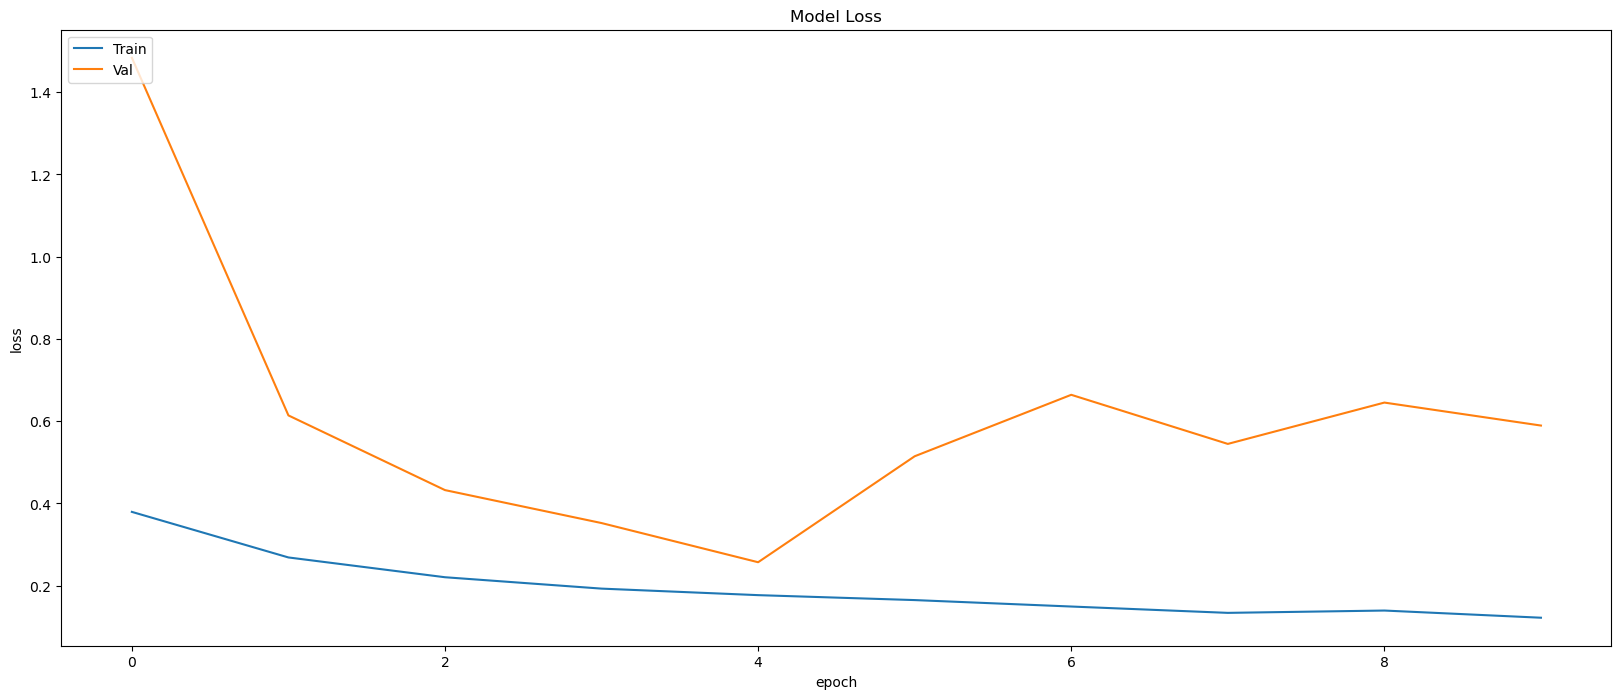

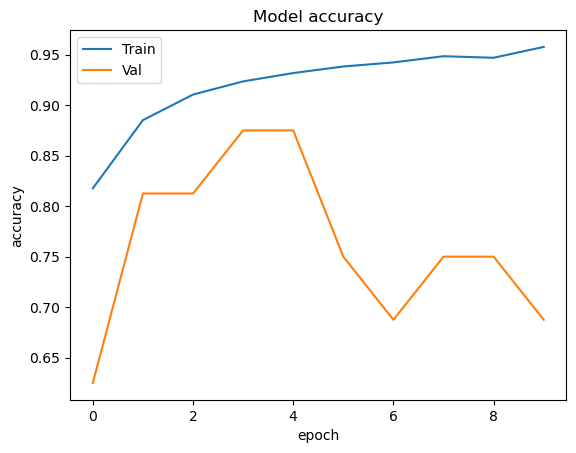

In [13]:
plt.figure(figsize=(20,8))
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history_df['accuracy'])
plt.plot(history_df['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Model 4 - RGB, drop out CNN

### Model 4.1 drop out - small

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


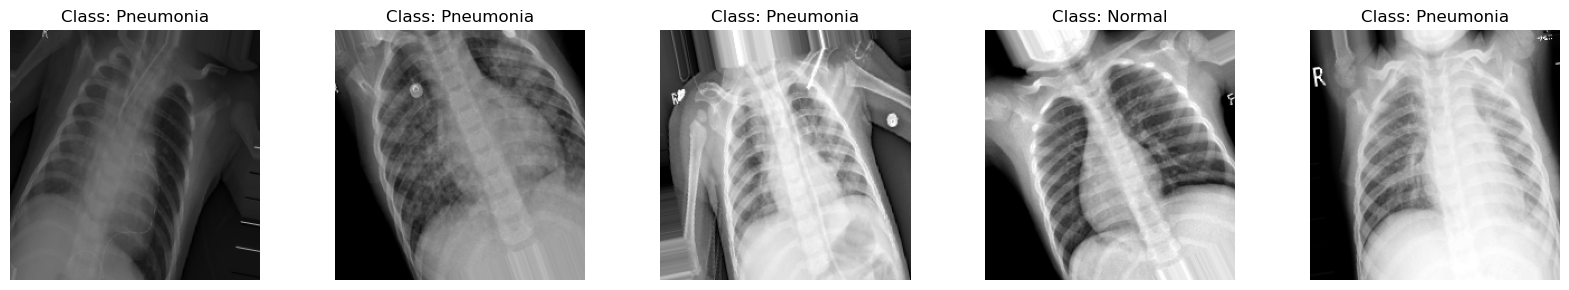

In [14]:
img_size = 224 # or 224
batch_size= 32 # default
color = 'rgb'

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range=30,
                                   brightness_range=[0.6,1.2],
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale = 1./255.,)
test_datagen = ImageDataGenerator(rescale = 1./255.,)

val_datagen = ImageDataGenerator(rescale=1/255.)

test_datagen = ImageDataGenerator(rescale=1/255.)


train_generator = train_datagen.flow_from_directory('chest_xray/train',
                                                    target_size= (img_size, img_size),
                                                    batch_size = batch_size,
                                                    color_mode=color, # default
                                                    shuffle = True,
                                                    class_mode ='binary',
                                                    seed = 99)

val_generator = val_datagen.flow_from_directory('chest_xray/val',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                color_mode=color, # default
                                                shuffle = False,
                                                class_mode ='binary',
                                                seed = 99)

test_generator = test_datagen.flow_from_directory('chest_xray/test',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                color_mode=color, # default
                                                shuffle = False, 
                                                class_mode ='binary',
                                                seed = 99)
labels = ['Normal','Pneumonia']
samples = train_generator.__next__()
images = samples[0]
target = samples[1]

plt.figure(figsize = (20 , 20))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[int(target[i])]}")
    plt.axis('off')
plt.show()

Epoch 1/10
163/163 [==============================] - 109s 660ms/step - loss: 0.4140 - accuracy: 0.8039 - recall_2: 0.9037 - val_loss: 1.2285 - val_accuracy: 0.5625 - val_recall_2: 1.0000
Epoch 2/10
163/163 [==============================] - 101s 621ms/step - loss: 0.2730 - accuracy: 0.8838 - recall_2: 0.9177 - val_loss: 0.4436 - val_accuracy: 0.8125 - val_recall_2: 0.8750
Epoch 3/10
163/163 [==============================] - 288s 2s/step - loss: 0.2146 - accuracy: 0.9133 - recall_2: 0.9373 - val_loss: 0.8722 - val_accuracy: 0.6875 - val_recall_2: 1.0000
Epoch 4/10
163/163 [==============================] - 2964s 18s/step - loss: 0.2023 - accuracy: 0.9191 - recall_2: 0.9458 - val_loss: 1.3500 - val_accuracy: 0.6250 - val_recall_2: 1.0000
Epoch 5/10
163/163 [==============================] - 108s 664ms/step - loss: 0.1703 - accuracy: 0.9365 - recall_2: 0.9566 - val_loss: 0.6228 - val_accuracy: 0.6875 - val_recall_2: 0.8750
Epoch 6/10
163/163 [==============================] - 100s 612ms

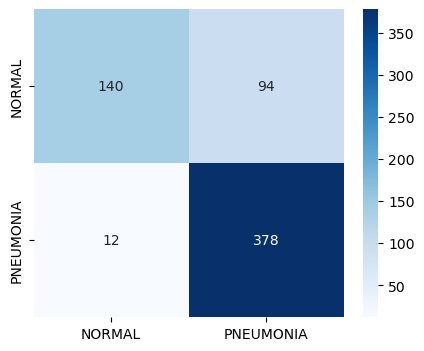

Accuracy of model is 83.01282051282051
Recall of model is 96.92307692307692
Precision of model is 80.08474576271186
F1 Score of model is 87.70301624129931


In [16]:
# https://www.kaggle.com/code/ishaparanjpe/pneumonia-detection 
channel = 3
cnn = Sequential()

cnn.add(Conv2D(16,3, input_shape=(img_size,img_size,channel), activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Conv2D(32,3, activation='relu', padding='same'))
cnn.add(Dropout(0.1))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Conv2D(64,3, activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))
cnn.add(Dropout(0.2))

cnn.add(Conv2D(64,3, activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Flatten())

cnn.add(Dense(256, activation ='relu'))
cnn.add(Dense(1, activation = 'sigmoid'))

cnn.compile(optimizer= 'nadam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy', tf.keras.metrics.Recall()])

history = cnn.fit(train_generator, 
                  validation_data= val_generator,
                  epochs = 10 # 200
                  #, callbacks= [checkpoint]
                 )

history_df = pd.DataFrame(history.history)
tester = cnn.evaluate(test_generator)
classes = test_generator.classes
y_preds = cnn.predict(test_generator)
y_pred_probs = y_preds.copy()
y_preds[y_preds>0.5] = 1
y_preds[y_preds<0.5] = 0
print(classification_report(classes,y_preds,target_names=labels))
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(classes,y_preds),annot=True,fmt='.3g',xticklabels=['NORMAL','PNEUMONIA'],
            yticklabels=['NORMAL','PNEUMONIA'],cmap='Blues')
plt.show()
acc = accuracy_score(classes,y_preds)
print(f'Accuracy of model is',acc*100)

recall_test = recall_score(classes,y_preds)
print(f'Recall of model is',recall_test*100)

prec = precision_score(classes,y_preds)
print(f'Precision of model is',prec*100)

f1 = f1_score(classes,y_preds)
print(f'F1 Score of model is', f1*100)

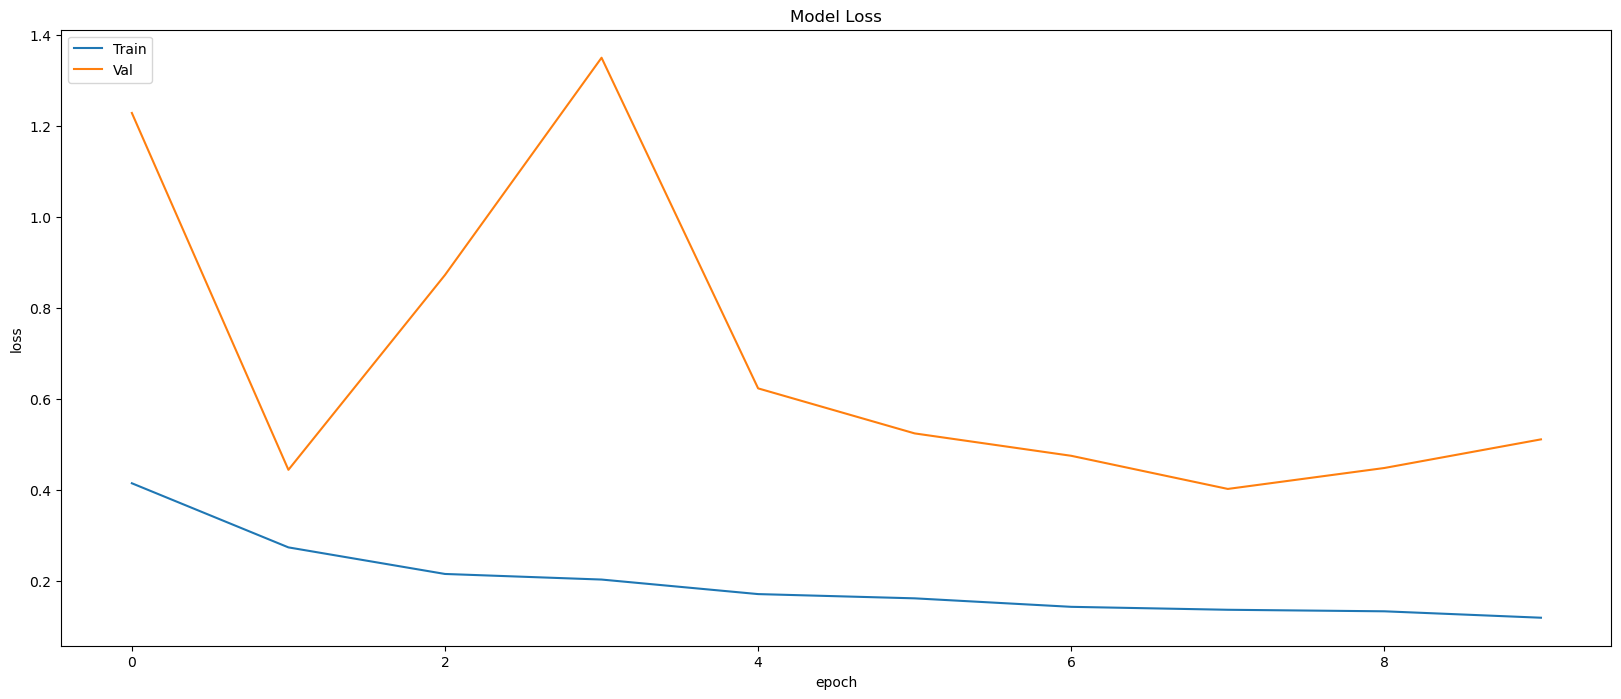

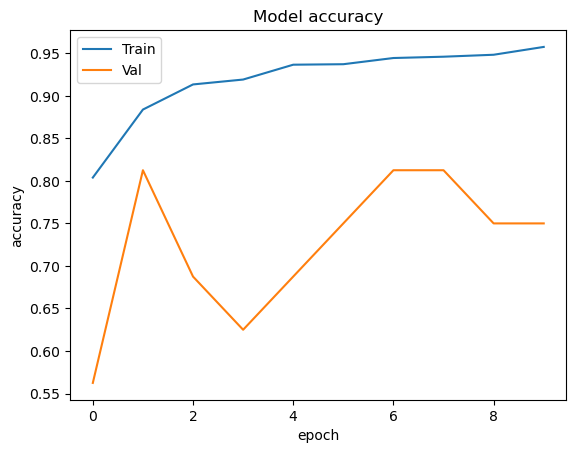

In [17]:
plt.figure(figsize=(20,8))
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history_df['accuracy'])
plt.plot(history_df['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### Model 4.2 - Dropout + Strides + BN - small

Epoch 1/10
163/163 [==============================] - 101s 613ms/step - loss: 0.3747 - accuracy: 0.8413 - recall_3: 0.9048 - val_loss: 0.6460 - val_accuracy: 0.5625 - val_recall_3: 1.0000
Epoch 2/10
163/163 [==============================] - 99s 605ms/step - loss: 0.2365 - accuracy: 0.9045 - recall_3: 0.9326 - val_loss: 0.5273 - val_accuracy: 0.7500 - val_recall_3: 1.0000
Epoch 3/10
163/163 [==============================] - 100s 614ms/step - loss: 0.1894 - accuracy: 0.9266 - recall_3: 0.9497 - val_loss: 0.4478 - val_accuracy: 0.8125 - val_recall_3: 0.8750
Epoch 4/10
163/163 [==============================] - 100s 612ms/step - loss: 0.1640 - accuracy: 0.9362 - recall_3: 0.9543 - val_loss: 0.8446 - val_accuracy: 0.6875 - val_recall_3: 1.0000
Epoch 5/10
163/163 [==============================] - 628s 4s/step - loss: 0.1439 - accuracy: 0.9461 - recall_3: 0.9608 - val_loss: 1.6012 - val_accuracy: 0.5625 - val_recall_3: 1.0000
Epoch 6/10
163/163 [==============================] - 101s 620ms

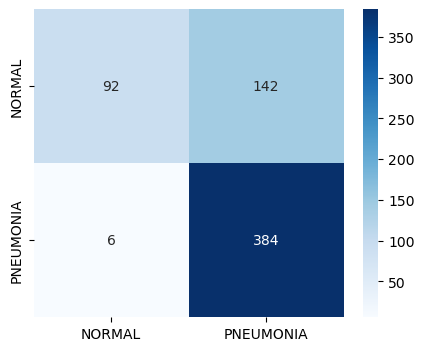

Accuracy of model is 76.28205128205127
Recall of model is 98.46153846153847
Precision of model is 73.00380228136882
F1 Score of model is 83.84279475982534


In [18]:
# https://www.kaggle.com/code/ishaparanjpe/pneumonia-detection 
channel = 3
cnn = Sequential()

cnn.add(Conv2D(16,3, input_shape=(img_size,img_size,channel), strides = 1, activation='relu', padding='same'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D((2,2) ,strides = 2, padding = 'same'))

cnn.add(Conv2D(32,3,strides = 1,  activation='relu', padding='same'))
cnn.add(Dropout(0.1))
cnn.add(MaxPooling2D((2,2),strides = 2, padding = 'same'))

cnn.add(Conv2D(64,3,strides = 1,  activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2),strides = 2 , padding = 'same'))
cnn.add(Dropout(0.2))

cnn.add(Conv2D(64,3,strides = 1,  activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2),strides = 2,  padding = 'same'))

cnn.add(Flatten())

cnn.add(Dense(256, activation ='relu'))
cnn.add(Dense(1, activation = 'sigmoid'))

cnn.compile(optimizer= 'nadam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy', tf.keras.metrics.Recall()])

history = cnn.fit(train_generator, 
                  validation_data= val_generator,
                  epochs = 10 # 200
                  #, callbacks= [checkpoint]
                 )

history_df = pd.DataFrame(history.history)
tester = cnn.evaluate(test_generator)
classes = test_generator.classes
y_preds = cnn.predict(test_generator)
y_pred_probs = y_preds.copy()
y_preds[y_preds>0.5] = 1
y_preds[y_preds<0.5] = 0
print(classification_report(classes,y_preds,target_names=labels))
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(classes,y_preds),annot=True,fmt='.3g',xticklabels=['NORMAL','PNEUMONIA'],
            yticklabels=['NORMAL','PNEUMONIA'],cmap='Blues')
plt.show()
acc = accuracy_score(classes,y_preds)
print(f'Accuracy of model is',acc*100)

recall_test = recall_score(classes,y_preds)
print(f'Recall of model is',recall_test*100)

prec = precision_score(classes,y_preds)
print(f'Precision of model is',prec*100)

f1 = f1_score(classes,y_preds)
print(f'F1 Score of model is', f1*100)

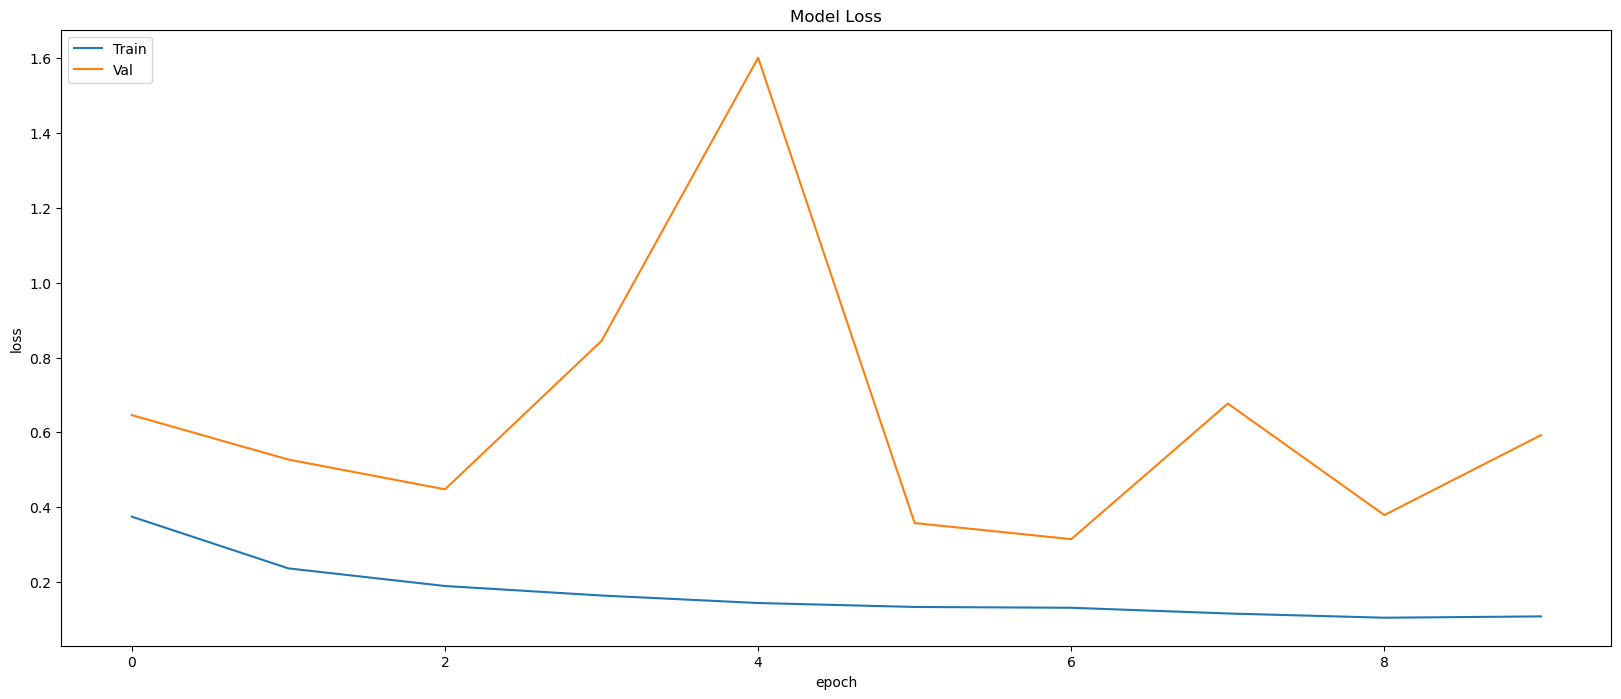

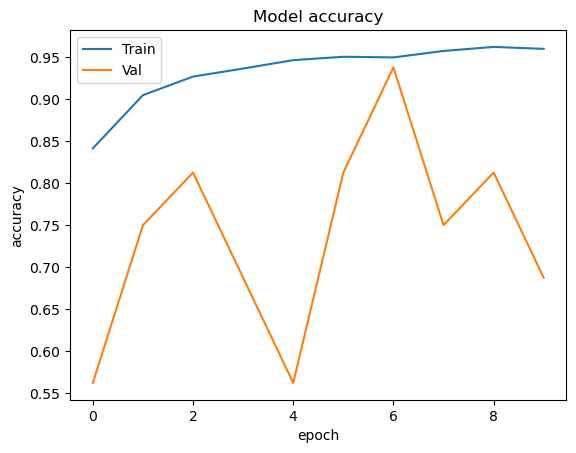

In [19]:
plt.figure(figsize=(20,8))
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history_df['accuracy'])
plt.plot(history_df['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### Model 4.3 - Dropout + Strides + BN - big

Epoch 1/12
163/163 [==============================] - 161s 973ms/step - loss: 0.4336 - accuracy: 0.8721 - recall_4: 0.9089 - val_loss: 28.5102 - val_accuracy: 0.5000 - val_recall_4: 1.0000
Epoch 2/12
163/163 [==============================] - 158s 968ms/step - loss: 0.2101 - accuracy: 0.9204 - recall_4: 0.9417 - val_loss: 18.5147 - val_accuracy: 0.5000 - val_recall_4: 1.0000
Epoch 3/12
163/163 [==============================] - 157s 962ms/step - loss: 0.1751 - accuracy: 0.9339 - recall_4: 0.9520 - val_loss: 3.5998 - val_accuracy: 0.5625 - val_recall_4: 1.0000
Epoch 4/12
163/163 [==============================] - 158s 963ms/step - loss: 0.1478 - accuracy: 0.9400 - recall_4: 0.9585 - val_loss: 1.1967 - val_accuracy: 0.5625 - val_recall_4: 0.1250
Epoch 5/12
163/163 [==============================] - 162s 988ms/step - loss: 0.1406 - accuracy: 0.9494 - recall_4: 0.9639 - val_loss: 1.7493 - val_accuracy: 0.5625 - val_recall_4: 1.0000
Epoch 6/12
163/163 [==============================] - 157s

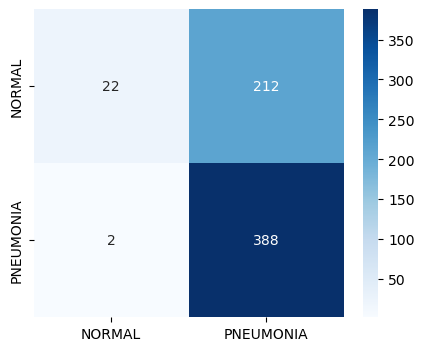

Accuracy of model is 65.7051282051282
Recall of model is 99.48717948717949
Precision of model is 64.66666666666666
F1 Score of model is 78.3838383838384


In [20]:
# https://www.kaggle.com/code/madz2000/pneumonia-detection-using-cnn-92-6-accuracy
channel = 3
cnn = Sequential()

cnn.add(Conv2D(32,3, input_shape=(img_size,img_size,channel), strides = 1, activation='relu', padding='same'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D((2,2) ,strides = 2, padding = 'same'))

cnn.add(Conv2D(64,3,strides = 1,  activation='relu', padding='same'))
cnn.add(Dropout(0.1))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D((2,2),strides = 2, padding = 'same'))

cnn.add(Conv2D(64,3,strides = 1,  activation='relu', padding='same'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D((2,2),strides = 2 , padding = 'same'))

cnn.add(Conv2D(128,3,strides = 1,  activation='relu', padding='same'))
cnn.add(Dropout(0.2))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D((2,2),strides = 2,  padding = 'same'))

cnn.add(Flatten())

cnn.add(Dense(128, activation ='relu'))
cnn.add(Dropout(0.1)) # interessting 
cnn.add(Dense(1, activation = 'sigmoid'))

cnn.compile(optimizer= 'nadam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy', tf.keras.metrics.Recall()])

history = cnn.fit(train_generator, 
                  validation_data= val_generator,
                  epochs = 12 # 200
                  #, callbacks= [checkpoint]
                 )

history_df = pd.DataFrame(history.history)
tester = cnn.evaluate(test_generator)
classes = test_generator.classes
y_preds = cnn.predict(test_generator)
y_pred_probs = y_preds.copy()
y_preds[y_preds>0.5] = 1
y_preds[y_preds<0.5] = 0
print(classification_report(classes,y_preds,target_names=labels))
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(classes,y_preds),annot=True,fmt='.3g',xticklabels=['NORMAL','PNEUMONIA'],
            yticklabels=['NORMAL','PNEUMONIA'],cmap='Blues')
plt.show()
acc = accuracy_score(classes,y_preds)
print(f'Accuracy of model is',acc*100)

recall_test = recall_score(classes,y_preds)
print(f'Recall of model is',recall_test*100)

prec = precision_score(classes,y_preds)
print(f'Precision of model is',prec*100)

f1 = f1_score(classes,y_preds)
print(f'F1 Score of model is', f1*100)

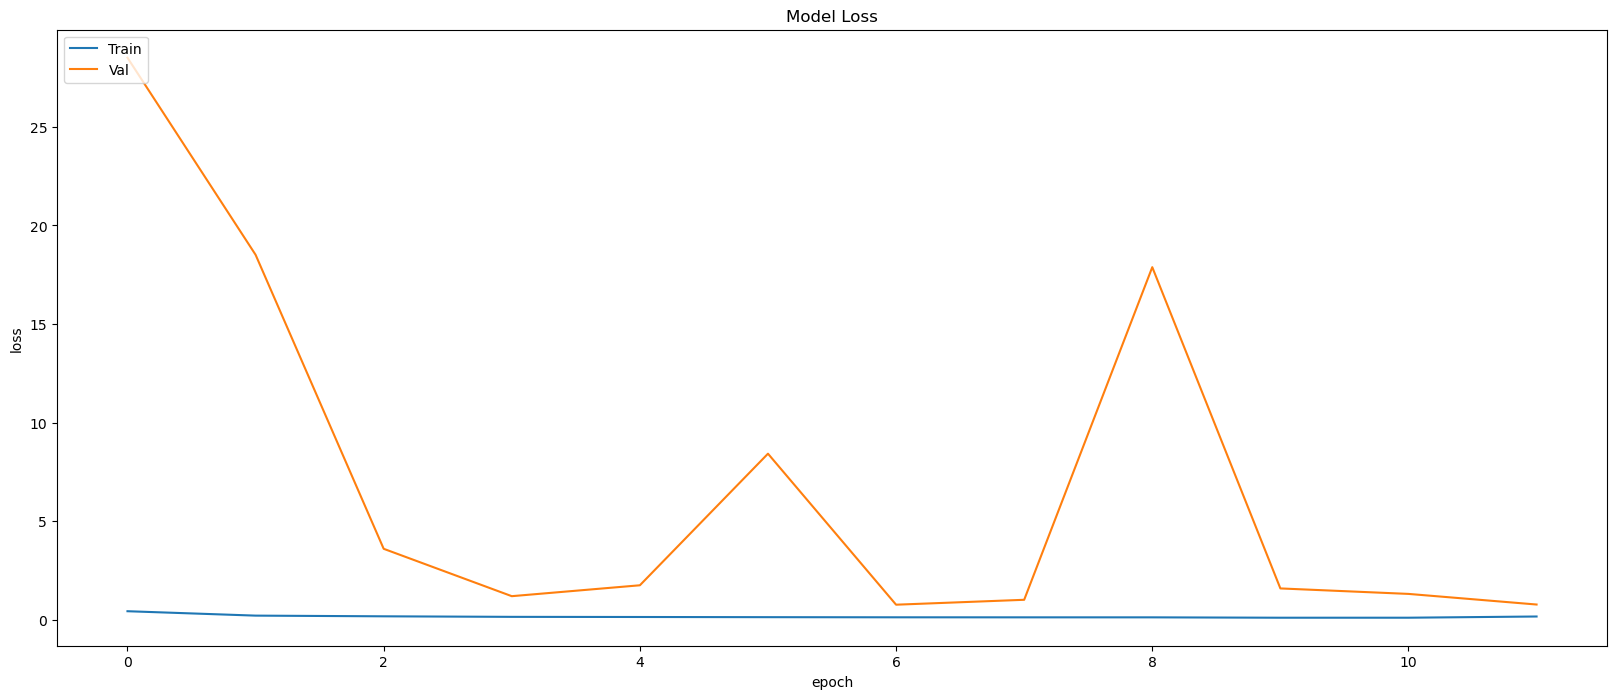

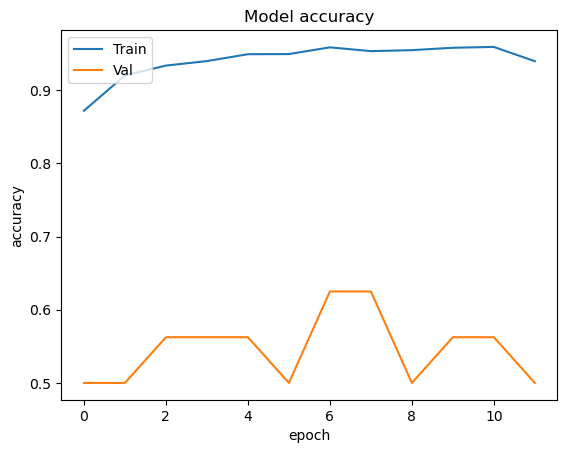

In [21]:
plt.figure(figsize=(20,8))
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history_df['accuracy'])
plt.plot(history_df['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
    model = Sequential()
    model.add(Conv2D(32, (3,3), input_shape=(img_size,img_size, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))

## Appendix 

**Data Augmentation**

In [ ]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
    
        rotation_range = 30, #0  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, #0.0 # Randomly zoom image 
        width_shift_range=0.1, #0.0 # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1, #0.0  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True, #False  # randomly flip images
    
        vertical_flip=False)  # randomly flip images

#### 
train_datagen = ImageDataGenerator(rescale=1.0/255.0, 
                                   shear_range = 0.2,
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)
###
train_datagen = ImageDataGenerator(rescale=1/255.,
                brightness_range=[0.1,1.1],
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip = True)  # randomly flip images



For the data augmentation, she choose to :

- Randomly rotate some training images by 30 degrees
- Randomly Zoom by 20% some training images
- Randomly shift images horizontally by 10% of the width
- Randomly shift images vertically by 10% of the height
- Randomly flip images horizontally. Once our model is ready, we fit the training dataset.

B) Normalization

Grayscale normalization: to reduce the effect of illumination's difference (also results in faster convergence of the CNN)

In [ ]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
# https://www.kaggle.com/code/srishtik05/normal-vs-pneumonia-cnn
model = Sequential()

model.add(Conv2D(32,(3,3),input_shape=(img_size,img_size,3),activation='relu',padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

# https://www.kaggle.com/code/thesnak/chest-xray-pneumonia-using-vgg19
channels = 3 # usually 1
cnn = Sequential()
cnn.add(InputLayer(input_shape=(img_size,img_size, channels)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=128))
cnn.add(Dense(activation='sigmoid', units=1))